# Import packages


In [160]:
import sys, os
sys.path.append('..') # add parent directory to path
from typing import List, Tuple

import numpy as np
import pandas as pd
# from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set the device to GPU if available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# ! pip install pyarrow fastparquet tqdm seaborn torch

In [4]:
# # Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

In [5]:
# load data
# ts = pd.read_pickle('data/test/counts_yellow_2023-01_2023-03.pkl')
ts = pd.read_pickle('data/test/adjusted_yellow_2022-01_2024-03_bypulocation.pkl') ## Fewer PU zones
# ts = pd.read_pickle('./drive/MyDrive/Data Science Projects/taxi-forecast/notebooks/data/test/counts_yellow_2023-01_2023-03.pkl')

# Drop 'total_amount'
# ts.drop(['total_amount'], axis=1, inplace=True)

# shape of data
print(ts.shape)

# sort
ts.sort_values(['PULocationID', 'pickup_datetime'], inplace=True)

ts.head()

# Number of PU zones
print(len(ts['PULocationID'].unique()))

(1236501, 9)
63


In [141]:
ts[ts["PULocationID"] == 12].head(50)

,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
1,12,2022-01-01 00:00:00-05:00,1,36.592499,6.088500,25.830000,5.600000,4.000000,22.650000
64,12,2022-01-01 01:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
127,12,2022-01-01 02:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
190,12,2022-01-01 03:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
253,12,2022-01-01 04:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
316,12,2022-01-01 05:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
379,12,2022-01-01 06:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
442,12,2022-01-01 07:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837
505,12,2022-01-01 08:00:00-05:00,1,16.974001,3.735154,12.915000,1.670000,1.000000,14.066667
568,12,2022-01-01 09:00:00-05:00,0,29.609848,3.735154,21.887640,4.144042,1.727924,19.171837


In [136]:
ts.groupby("PULocationID").sum("counts").sort_values("counts")

,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
PULocationID,,,,,,,
120,190,852578.06250,190020.796875,689639.062500,77562.804688,27477.798828,232893.312500
128,224,501908.15625,115203.578125,417580.843750,83655.421875,27042.630859,334245.156250
127,2524,584455.87500,111186.882812,502438.843750,100918.632812,25296.025391,402758.625000
243,6526,521176.03125,96524.773438,427686.062500,81077.390625,27428.099609,334295.187500
12,31145,581152.50000,73309.867188,429588.718750,81335.125000,33913.953125,376285.625000
...,...,...,...,...,...,...,...
186,2601680,411197.87500,51851.320312,269085.250000,39066.687500,26841.732422,260277.796875
162,2613701,379207.87500,48748.550781,240616.453125,36104.289062,26458.378906,215858.406250
161,3309479,385270.50000,49145.664062,246361.203125,36452.945312,27487.794922,224657.218750


# Preprocess data for modelling

Uncomment the print lines to check the tensors and their dimensions

In [144]:
# Drop zone with very sparse time series
n_top_zones = 50
n_bottom_zones = 1
selected_zones_df = ts.groupby('PULocationID')['counts'].sum().sort_values(ascending=False)[:-n_bottom_zones]
selected_zones = selected_zones_df.index.to_list()
selected_zones_df

PULocationID
237    3737511
236    3336203
161    3309479
162    2613701
186    2601680
        ...   
244      42385
12       31145
243       6526
127       2524
128        224
Name: counts, Length: 62, dtype: int32

In [145]:
# Remap zone ID to [0, 1, 2,...] in order to work with nn.Embedding()
def zone_mapping(taxi_data):
    zone_list = sorted(list(taxi_data['PULocationID'].unique()))
    zone_dict = dict(zip(zone_list, range(len(zone_list))))
    return zone_dict

# selected_zones = [56, 79, 90]
# Filter data with selected zones
selected_ts = ts[ts['PULocationID'].isin(selected_zones)].copy()
print('zones: ', selected_ts['PULocationID'].unique())
display(selected_ts.head())

zone_dict = zone_mapping(selected_ts)
n_zones = len(zone_dict)
selected_ts['zone_id'] = selected_ts['PULocationID'].map(zone_dict)

zones:  [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 107 113 114 116 125 127 128 137 140 141 142 143 144 148 151 152 158 161
 162 163 164 166 170 186 209 211 224 229 230 231 232 233 234 236 237 238
 239 243 244 246 249 261 262 263]


,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,4,2022-01-01 00:00:00-05:00,8,23.242388,1.886513,16.681875,3.363750,1.375000,14.481250
63,4,2022-01-01 01:00:00-05:00,9,23.471134,2.943800,15.853334,3.298889,1.888889,13.685184
126,4,2022-01-01 02:00:00-05:00,22,18.976105,2.896650,11.405455,2.087273,1.772727,9.458334
189,4,2022-01-01 03:00:00-05:00,5,19.746420,2.034420,13.038001,2.504000,1.600000,11.223333
252,4,2022-01-01 04:00:00-05:00,5,20.710741,0.615000,15.544741,2.632000,1.200000,11.460000


In [146]:
selected_ts

,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration,zone_id
0,4,2022-01-01 00:00:00-05:00,8,23.242388,1.886513,16.681875,3.363750,1.375000,14.481250,0
63,4,2022-01-01 01:00:00-05:00,9,23.471134,2.943800,15.853334,3.298889,1.888889,13.685184,0
126,4,2022-01-01 02:00:00-05:00,22,18.976105,2.896650,11.405455,2.087273,1.772727,9.458334,0
189,4,2022-01-01 03:00:00-05:00,5,19.746420,2.034420,13.038001,2.504000,1.600000,11.223333,0
252,4,2022-01-01 04:00:00-05:00,5,20.710741,0.615000,15.544741,2.632000,1.200000,11.460000,0
...,...,...,...,...,...,...,...,...,...,...
1236248,263,2024-03-31 19:00:00-04:00,78,16.183334,2.029487,10.134615,1.624231,1.333333,7.688675,61
1236311,263,2024-03-31 20:00:00-04:00,70,18.672571,2.578286,11.130000,1.879571,1.428571,8.332857,61
1236374,263,2024-03-31 21:00:00-04:00,61,19.478851,2.141803,12.394426,1.955574,1.098361,8.524590,61
1236437,263,2024-03-31 22:00:00-04:00,26,19.896152,2.365385,12.530768,2.263846,1.153846,8.896795,61


In [147]:
# Correlation is high between total amount and fare amount, all of the other are strongly correlated, but not excessively so
selected_ts.loc[:, ("fare_amount", "trip_duration", "trip_distance", "tip_amount", "total_amount")].corr()

,fare_amount,trip_duration,trip_distance,tip_amount,total_amount
fare_amount,1.000000,0.737089,0.808715,0.569016,0.947412
trip_duration,0.737089,1.000000,0.615961,0.422132,0.698271
trip_distance,0.808715,0.615961,1.000000,0.510243,0.753551
tip_amount,0.569016,0.422132,0.510243,1.000000,0.660910
total_amount,0.947412,0.698271,0.753551,0.660910,1.000000


In [148]:
# Pivot wide: each colunm is a time series of a zone
value_cols = ['counts', 'fare_amount', 'tip_amount', 'trip_distance', 'trip_duration']
ts_multi = selected_ts.pivot(index='pickup_datetime', columns='zone_id',  values=value_cols)
display(ts_multi.head())

n_covars = len(value_cols)
# add time variables, time step number, day of week, month number, holiday flag, , hour number
# train variant without duration

counts                                         \
zone_id                       0    1     2     3     4    5     6    7    
pickup_datetime                                                           
2022-01-01 00:00:00-05:00    8.0  1.0  10.0  10.0   9.0  2.0  89.0  9.0   
2022-01-01 01:00:00-05:00    9.0  0.0   6.0  13.0  13.0  4.0  54.0  4.0   
2022-01-01 02:00:00-05:00   22.0  0.0   3.0   3.0   5.0  5.0  19.0  3.0   
2022-01-01 03:00:00-05:00    5.0  0.0   0.0   2.0  12.0  3.0   7.0  1.0   
2022-01-01 04:00:00-05:00    5.0  0.0   0.0   2.0   2.0  0.0   4.0  1.0   

                                         ... trip_duration             \
zone_id                       8      9   ...            52         53   
pickup_datetime                          ...                            
2022-01-01 00:00:00-05:00  136.0   69.0  ...     10.074516  10.403095   
2022-01-01 01:00:00-05:00  195.0  100.0  ...      9.158504   9.983056   
2022-01-01 02:00:00-05:00  191.0   90.0  ...      7.881560  10.727083   
2022-01-01 03:00:00-05:00  162.0   38.0  ...      8.240351   9.244445   
2022-01-01 04:00:00-05:00  102.0   19.0  ...      7.272223   7.994444   

                                                                       \
zone_id                           54         55         56         57   
pickup_datetime                                                         
2022-01-01 00:00:00-05:00  10.272392  11.833333  11.127777  14.168571   
2022-01-01 01:00:00-05:00  10.541358  17.032413  11.641667  11.968493   
2022-01-01 02:00:00-05:00  10.994552   8.566667  15.168828  12.137797   
2022-01-01 03:00:00-05:00  10.346492  17.032413  15.168828  10.183088   
2022-01-01 04:00:00-05:00   8.795556  17.032413   2.416667   9.840740   

                                                                      
zone_id                           58         59         60        61  
pickup_datetime                                                       
2022-01-01 00:00:00-05:00  12.456313  14.230000   9.255915  7.873433  
2022-01-01 01:00:00-05:00  12.220030  14.291111   7.202899  8.452817  
2022-01-01 02:00:00-05:00  11.012191  15.910605   7.953968  8.219406  
2022-01-01 03:00:00-05:00  10.190166  16.777084   7.525000  7.188798  
2022-01-01 04:00:00-05:00  11.881112   8.258333  10.766666  7.809896  

[5 rows x 310 columns]

In [149]:
# Function to reindex the list of sequences --> resulting re-indexed list of sequence 
# is ready to be batched while maintaining the time line through batches
def group_chunks(data, batch_size):
    num_batches = len(data) // batch_size
    new_ds = []
    for batch_idx in range(num_batches):
        re_indexed_batch = list(data[batch_idx + num_batches*j] for j in range(batch_size))
        # print('batch length: ', len(re_indexed_batch))
        new_ds += re_indexed_batch
    return new_ds

In [150]:
data = ts_multi
# print(type(data))
# print(data.shape)
# display(data)
# print()

# TODO: Move scaling to after the train/test split

# Normalize data - standardize each column independently
# scaler1 normalizes the count columns (to reverse tranform on the target later)
scaler1 = MinMaxScaler()
data1 = scaler1.fit_transform(data.iloc[:, :n_zones])

# scaler2 normalizes other columns
scaler2 = MinMaxScaler()
data2 = scaler2.fit_transform(data.iloc[:, n_zones:])

# then concat all normalized columns
data = np.concatenate([data1, data2], axis=1)
# Transpose --> each row is a time series for a given zone
data = data.T
# Convert data to PyTorch tensors and move to gpu
data = torch.tensor(data, dtype=torch.float32).to(device)

In [151]:
def prepare_seqs(data, n_zones: int, sequence_length: int) -> List[List[Tuple[torch.tensor, torch.tensor]]]:
    # Prepare the data into list of sequences (pair of input and target sequences)
    # Top level list contains one list for each zone
    # Next level contains tuples of traning data and the target sequence
    # data_pp will be a list of lists, each inner list contain the slices of info over time for each zone
    data_pp = []   
    
    for z in range(n_zones):
        # TODO: Fix this in the other versions
        zone_series = data[z::n_zones, :]
        series_length = zone_series.shape[-1]
        sequence_idxs = range(0, series_length - sequence_length - 1, sequence_length)
        zone_series_pp = [(
            zone_series[:, seq_idx:     seq_idx + sequence_length    ], 
            zone_series[0, seq_idx + 1: seq_idx + sequence_length + 1]
        ) for seq_idx in sequence_idxs]

        data_pp.append(zone_series_pp)
    return data_pp


sequence_length = 24 # size of each slide (over time)
batch_size = n_zones # This is the number of zones

data_pp = prepare_seqs(data, n_zones, sequence_length)

In [152]:
batch_size = n_zones # This is the number of zones

def pp_to_chunks(data_pp: List[List[Tuple[torch.tensor, torch.tensor]]], batch_size, train_portion=0.8) -> Tuple[List[Tuple[torch.tensor, torch.tensor]], List[Tuple[torch.tensor, torch.tensor]]]:
    cut_idx = int(len(data_pp[0]) * train_portion)    
    # Split into train and test for each zone's data
    zone_train_data = [zone_seq[:cut_idx] for zone_seq in data_pp]
    zone_valid_data = [zone_seq[cut_idx:] for zone_seq in data_pp]
    zone_data = (zone_train_data, zone_valid_data)
    zone_chunks = []
    for zone_data_series in zone_data:
        flattened_zones = [i for zone_seq in zone_data_series for i in zone_seq]
        print(len(flattened_zones))
        zone_chunks.append(group_chunks(flattened_zones, batch_size))
    return zone_chunks

# Create Train and Validation sets - fix cutoff index to drop last few obs that are not enough to formm a batch
cut = int(len(data_pp[0]) * 0.8)

# train_data = [s[:cut] for s in data_pp]
# valid_data = [s[cut:] for s in data_pp] 
# print('length of train_data: ', len(train_data))
# print('length of each series in train_data: ', len(train_data[0]))
# print('first item of train_data[0]: ', train_data[0][0])
# print('length of each series in valid_data: ', len(valid_data[0]))
# print()

# Concatenate the 3 series into a long chain
# train_set = [i for s in train_data for i in s ]
# valid_set = [i for s in valid_data for i in s ]
# print('length of concat train set: ', len(train_set))
# print('length of concat valid set: ', len(valid_set))
# print('first item of train_set[0]: ', train_set[0])
# print()

# Reindex with group_chunks() --> Concatenate & Reindex helps with dataloader which takes in a list
# train_set = group_chunks(train_set, batch_size)
# valid_set = group_chunks(valid_set, batch_size)
# print('length of reindexed train set: ', len(train_set))
# print('length of reindexed valid set: ', len(valid_set))
# print()


train_set, valid_set = pp_to_chunks(data_pp, batch_size, train_portion=0.8)


40486
10168


In [153]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# Check size of Train and Validation sets in the dataloaders
print('N batches in train loader: ', len(list(train_loader)))
print('N batches in valid loader: ', len(list(valid_loader)))
print()

# # shape of first batch: 2 stacks
# print('shape of first batch (2 stacks) in train set: ')
# print(list(train_loader)[0]) # first batch
# print(list(train_loader)[0][0].size()) # input
# print(list(train_loader)[0][1].size()) # target
# print()

# # first pair of input & target in the first batch --> First time step of zone 1
# print('first pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][0]) # input
# print(list(train_loader)[0][1][0]) # target
# print()

# # second pair of input & target in the first batch --> First time step of zone 2 
# print('second pair of input & target in the first batch in train set: ')
# print(list(train_loader)[0][0][1]) # input
# print(list(train_loader)[0][1][1]) # target
# print()

# # first pair of input & target in the second batch --> Second time step of zone 1
# print('first pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][0]) # input
# print(list(train_loader)[1][1][0]) # target
# print()

# # second pair of input & target in the second batch --> Second time step of zone 2
# print('second pair of input & target in the second batch in train set: ')
# print(list(train_loader)[1][0][1]) # input
# print(list(train_loader)[1][1][1]) # target
# print()

N batches in train loader:  653
N batches in valid loader:  164



# Modelling

## RNN

In [154]:
class RNN_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=n_covars, hidden_size=50, output_size=1, num_layers=1):
        super(RNN_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.rnn = nn.RNN(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = torch.zeros(num_layers, batch_size, hidden_size).to(device)

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.rnn(x, self.h)
        self.h = h.detach()
        out = self.fc(out)
        return out

    def reset(self): self.h.zero_()

In [155]:
input_size = n_covars
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(selected_ts['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = RNN_MultiSeries_Model(embed_dim_inputs, 
                              input_size, 
                              hidden_size, 
                              output_size, 
                              num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (62, 31)


In [156]:
def transform_batch(batch_X, batch_y):
    batch_X = batch_X.moveaxis(-2, -1)
    batch_y = batch_y.unsqueeze(dim=-1)
    return batch_X, batch_y

In [157]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

def train_epoch(train_loader, model, criterion, zone_id_list):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)

        preds = model(zone_id_list, batch_X)

        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()
    
    return avg_train_loss

def validate_epoch(valid_loader, model, criterion, zone_id_list):
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X, batch_y = transform_batch(batch_X, batch_y)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()
    
    return avg_valid_loss


valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)

        preds = model(zone_id_list, batch_X)

        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X, batch_y = transform_batch(batch_X, batch_y)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0050, Validation Loss: 0.0050
Epoch [20/1000], Train Loss: 0.0048, Validation Loss: 0.0050
Epoch [30/1000], Train Loss: 0.0047, Validation Loss: 0.0048
Epoch [40/1000], Train Loss: 0.0046, Validation Loss: 0.0048
Epoch [50/1000], Train Loss: 0.0046, Validation Loss: 0.0047
Epoch [60/1000], Train Loss: 0.0046, Validation Loss: 0.0049
Epoch [70/1000], Train Loss: 0.0046, Validation Loss: 0.0049


In [164]:
def smape(y, y_pred):
    # From pytorch-forecasting
    return np.mean(2*np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))

smape(test_preds, test_target)

0.5918227

: 

Test Loss: 0.0051


C:\Users\noahj\AppData\Local\Temp\ipykernel_12532\3268950977.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


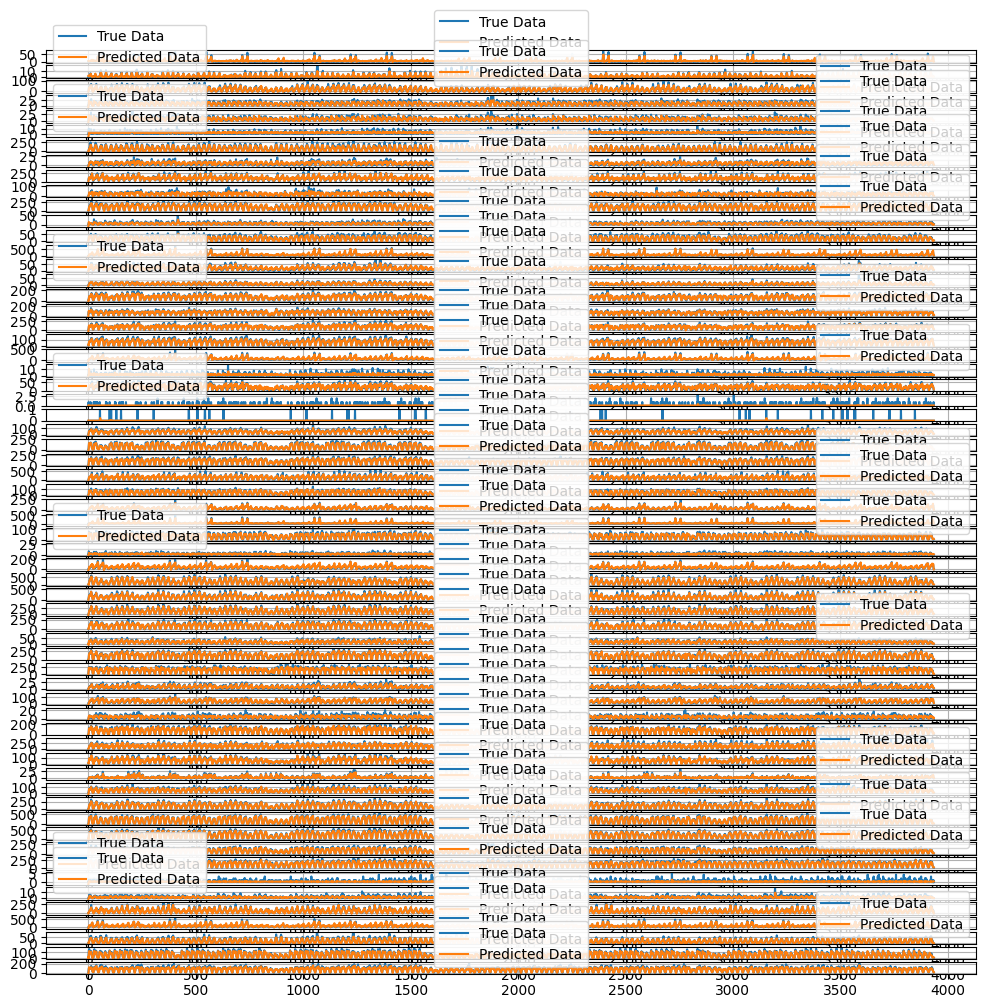

In [158]:



model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    test_smape = 
    print(f'Test Loss: {test_loss.item():.4f}')
    
    
    # Change the dimension to work with scaler
    test_preds = test_preds.cpu().numpy().squeeze(-1).T
    test_target = test_target.cpu().numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler1.inverse_transform(test_preds)
    test_target = scaler1.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 12))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()


## LSTM

In [179]:
class LSTM_MultiSeries_Model(nn.Module):
    def __init__(self, embed_dim_inputs, input_size=n_covars, hidden_size=50, output_size=1, num_layers=1):
        super(LSTM_MultiSeries_Model, self).__init__()
        self.cat_embed = nn.Embedding(embed_dim_inputs[0], embed_dim_inputs[1])
        # self.embed_dropout = nn.Dropout(0.4)
        self.lstm = nn.LSTM(embed_dim_inputs[1] + input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h = [torch.zeros(num_layers, batch_size, hidden_size) for _ in range(2)]

    def forward(self, x_cat, x_cont):
        emb = self.cat_embed(x_cat)
        # Expand the embedding matrix to concatenate to the continuous times series
        emb_expanded = emb.unsqueeze(dim=-2).expand((-1, x_cont.size(-2), -1)) 
        # emb_expanded = self.embed_dropout(emb_expanded)
        x = torch.cat([emb_expanded, x_cont], dim=-1)
        out, h = self.lstm(x, self.h)
        self.h = [h_.detach() for h_ in h]
        out = self.fc(out)
        return out

    def reset(self): 
        for h in self.h: h.zero_()

In [180]:
input_size = n_covars
hidden_size = 50
output_size = 1
num_layers = 1

zone_id_list = torch.tensor(sorted(list(ts_2['zone_id'].unique()))).long().to(device)
embed_dim_inputs = len(zone_id_list), min(50, (len(zone_id_list)+1)//2)
print('dimension', embed_dim_inputs)

model = LSTM_MultiSeries_Model(embed_dim_inputs, 
                               input_size,
                               hidden_size,
                               output_size,
                               num_layers).to(device)
criterion = nn.MSELoss()
mape_criterion = nn.Loss
optimizer = optim.Adam(model.parameters(), lr=3e-3)


dimension (2, 1)


In [181]:
# Training loop for multiple series RNN/LSTM
num_epochs = 1000

## to keep track of if validation loss went up
times_valid_loss_went_up_in_a_row = 0

## an initial value
min_valid_loss = float("inf")

valid_loss_list = []

for epoch in range(num_epochs):
    ## Train
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        
        batch_X, batch_y = transform_batch(batch_X, batch_y)

        preds = model(zone_id_list, batch_X)
        train_loss = criterion(preds, batch_y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    model.reset()

    ## Validate
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
        
            batch_X, batch_y = transform_batch(batch_X, batch_y)
            
            preds = model(zone_id_list, batch_X)
            valid_loss = criterion(preds, batch_y)

            epoch_valid_loss += valid_loss.item()
    
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    model.reset()

    ## print out Train and Valiation loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    ## Early Stopping: check if the error went up or down
    valid_loss_list.append(avg_valid_loss)

    # if it went down
    if valid_loss_list[-1] < min_valid_loss:
        # record the new minimum val error
        min_valid_loss = valid_loss_list[-1]

        # reset our up counter
        times_valid_loss_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_valid_loss_went_up_in_a_row = times_valid_loss_went_up_in_a_row + 1
        # if this is the 20th time in a row it has gone up
        if times_valid_loss_went_up_in_a_row == 20:
            # stop early
            break

Epoch [10/1000], Train Loss: 0.0070, Validation Loss: 0.0084
Epoch [20/1000], Train Loss: 0.0065, Validation Loss: 0.0070
Epoch [30/1000], Train Loss: 0.0044, Validation Loss: 0.0048
Epoch [40/1000], Train Loss: 0.0039, Validation Loss: 0.0044
Epoch [50/1000], Train Loss: 0.0039, Validation Loss: 0.0041
Epoch [60/1000], Train Loss: 0.0036, Validation Loss: 0.0040
Epoch [70/1000], Train Loss: 0.0036, Validation Loss: 0.0038
Epoch [80/1000], Train Loss: 0.0034, Validation Loss: 0.0039
Epoch [90/1000], Train Loss: 0.0036, Validation Loss: 0.0040
Epoch [100/1000], Train Loss: 0.0032, Validation Loss: 0.0036


Test Loss: 0.0037


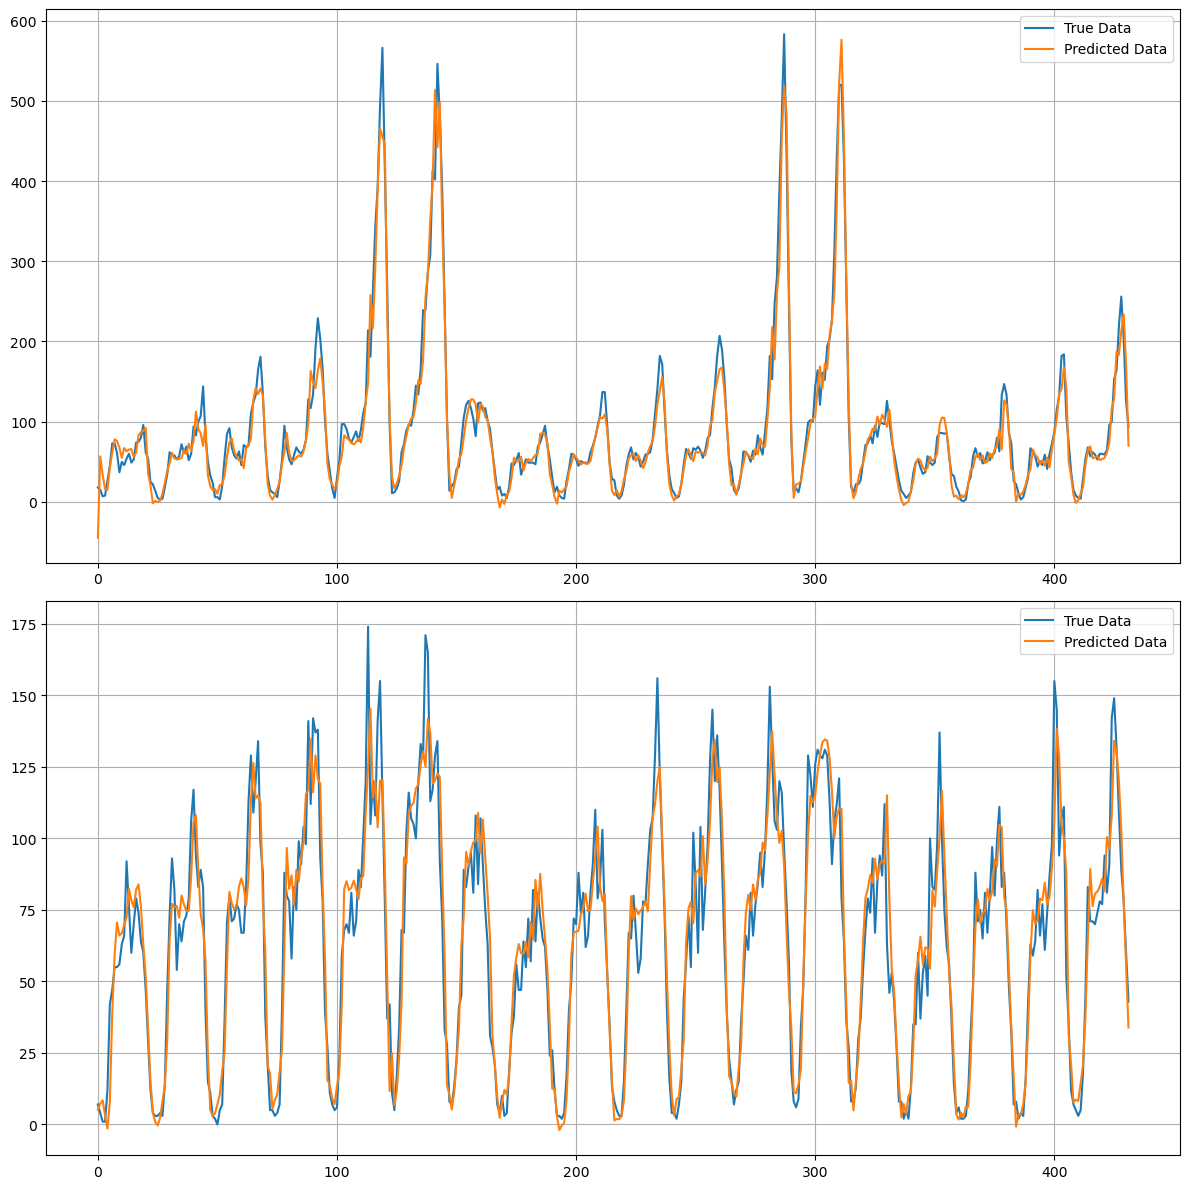

In [183]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_target = []

    for batch_X, batch_y in valid_loader:
        batch_X = batch_X.moveaxis(-2, -1)
        batch_y = batch_y.unsqueeze(dim=-1)
        
        preds = model(zone_id_list, batch_X)
        
        test_preds.append(preds)
        test_target.append(batch_y)
         
    test_preds = torch.cat(test_preds, dim=-2)
    test_target = torch.cat(test_target, dim=-2)
    
    test_loss = criterion(test_preds, test_target)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Change the dimension to work with scaler
    test_preds = test_preds.numpy().squeeze(-1).T
    test_target = test_target.numpy().squeeze(-1).T
    
    # Inverse transform to get the original scale
    test_preds = scaler1.inverse_transform(test_preds)
    test_target = scaler1.inverse_transform(test_target)
    
    # Transpose again
    test_preds = test_preds.T
    test_target = test_target.T
    
    # Plot
    fig, axs = plt.subplots(len(zone_id_list), 1, figsize=(12, 12))
    for c in range(test_target.shape[0]):   
        axs[c].plot(range(test_target.shape[1]), test_target[c], label='True Data')
        axs[c].plot(range(test_target.shape[1]), test_preds[c], label='Predicted Data')
        axs[c].legend()
        axs[c].grid(True)
    plt.tight_layout()
    plt.show()
